# Variational AutoEncoder to create Embedding for tabular data

In [1]:
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

%matplotlib inline

## Data Preparation

In [2]:
df = pd.read_csv('merchants.csv')
print(df.shape)
df

(334696, 22)


,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
0,M_ID_838061e48c,8353,792,9,-0.057471,-0.057471,N,E,E,-0.40,9.666667,3,-2.25,18.666667,6,-2.32,13.916667,12,N,242,9,1.0
1,M_ID_9339d880ad,3184,840,20,-0.057471,-0.057471,N,E,E,-0.72,1.750000,3,-0.74,1.291667,6,-0.57,1.687500,12,N,22,16,1.0
2,M_ID_e726bbae1e,447,690,1,-0.057471,-0.057471,N,E,E,-82.13,260.000000,2,-82.13,260.000000,2,-82.13,260.000000,2,N,-1,5,5.0
3,M_ID_a70e9c5f81,5026,792,9,-0.057471,-0.057471,Y,E,E,NaN,1.666667,3,NaN,4.666667,6,NaN,3.833333,12,Y,-1,-1,NaN
4,M_ID_64456c37ce,2228,222,21,-0.057471,-0.057471,Y,E,E,NaN,0.500000,3,NaN,0.361111,6,NaN,0.347222,12,Y,-1,-1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334691,M_ID_1f4773aa76,1145,705,33,3.174788,-0.047556,N,A,A,1.00,1.022618,3,0.99,1.019505,6,1.00,1.024796,12,Y,69,9,1.0
334692,M_ID_725a60d404,35,544,29,-0.057471,-0.057471,Y,A,A,0.89,0.927684,3,0.78,0.813473,6,0.59,0.606765,12,Y,-1,-1,NaN
334693,M_ID_f2045dd267,35,561,7,-0.057471,-0.057471,N,A,A,0.96,0.982957,3,0.90,0.924769,6,0.74,0.750763,8,Y,160,21,5.0
334694,M_ID_9139332ccc,35,511,7,-0.057471,-0.057471,Y,A,A,0.94,0.919558,3,0.82,0.783000,6,0.65,0.584000,12,Y,-1,-1,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334696 entries, 0 to 334695
Data columns (total 22 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   merchant_id                  334696 non-null  object 
 1   merchant_group_id            334696 non-null  int64  
 2   merchant_category_id         334696 non-null  int64  
 3   subsector_id                 334696 non-null  int64  
 4   numerical_1                  334696 non-null  float64
 5   numerical_2                  334696 non-null  float64
 6   category_1                   334696 non-null  object 
 7   most_recent_sales_range      334696 non-null  object 
 8   most_recent_purchases_range  334696 non-null  object 
 9   avg_sales_lag3               334683 non-null  float64
 10  avg_purchases_lag3           334696 non-null  float64
 11  active_months_lag3           334696 non-null  int64  
 12  avg_sales_lag6               334683 non-null  float64
 13 

#### Fix a missing values

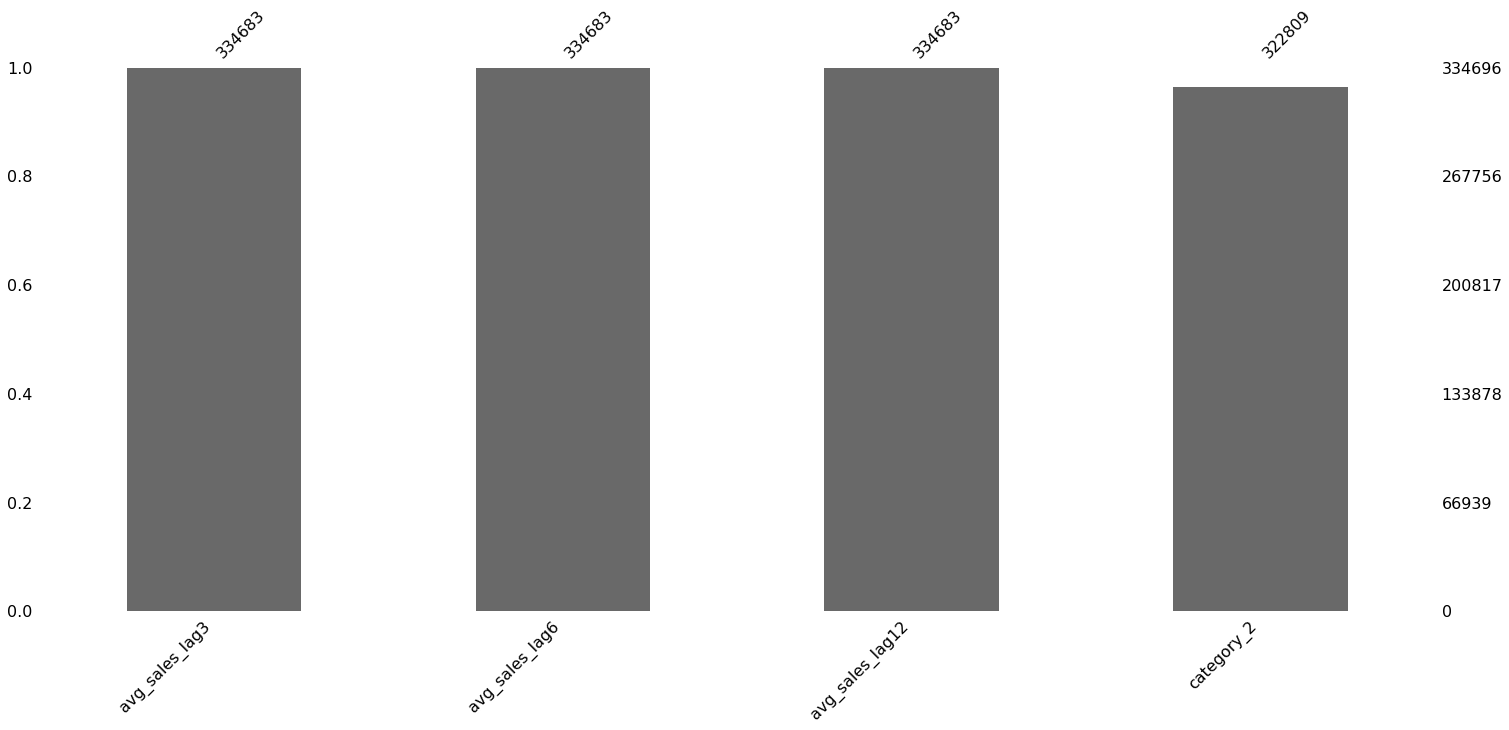

In [4]:
# Filter only missing values
null_columns=df.columns[df.isnull().any()]
msno.bar(df[null_columns])

In [5]:
for c in ['avg_sales_lag3', 'avg_sales_lag6', 'avg_sales_lag12']:
    df[c] = df[c].fillna(df[c].mean())

In [6]:
# add other category 
df['category_2'] = df.category_2.fillna(df.category_2.max()+1)
# replace inf to zero
df = df.replace([np.inf, -np.inf], np.nan).fillna(0)
#merchant_group_id
categorical_columns = ['merchant_category_id','subsector_id',
                       'category_1', 'most_recent_sales_range', 'most_recent_purchases_range',
                       'category_4', 'city_id', 'state_id', 'category_2']

df_enc = pd.get_dummies(df, columns=categorical_columns)
print(df_enc.shape)
df_enc.head()

(334696, 694)


,merchant_id,merchant_group_id,numerical_1,numerical_2,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,merchant_category_id_-1,merchant_category_id_2,merchant_category_id_9,merchant_category_id_11,merchant_category_id_14,merchant_category_id_16,merchant_category_id_18,merchant_category_id_19,merchant_category_id_21,merchant_category_id_31,merchant_category_id_33,merchant_category_id_34,merchant_category_id_36,merchant_category_id_38,merchant_category_id_40,merchant_category_id_45,merchant_category_id_49,merchant_category_id_52,merchant_category_id_53,merchant_category_id_56,merchant_category_id_57,merchant_category_id_59,merchant_category_id_60,merchant_category_id_63,merchant_category_id_67,merchant_category_id_68,merchant_category_id_69,...,city_id_337,city_id_338,city_id_339,city_id_340,city_id_341,city_id_342,city_id_343,city_id_345,city_id_347,state_id_-1,state_id_1,state_id_2,state_id_3,state_id_4,state_id_5,state_id_6,state_id_7,state_id_8,state_id_9,state_id_10,state_id_11,state_id_12,state_id_13,state_id_14,state_id_15,state_id_16,state_id_17,state_id_18,state_id_19,state_id_20,state_id_21,state_id_22,state_id_23,state_id_24,category_2_1.0,category_2_2.0,category_2_3.0,category_2_4.0,category_2_5.0,category_2_6.0
0,M_ID_838061e48c,8353,-0.057471,-0.057471,-0.400000,9.666667,3,-2.250000,18.666667,6,-2.320000,13.916667,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,M_ID_9339d880ad,3184,-0.057471,-0.057471,-0.720000,1.750000,3,-0.740000,1.291667,6,-0.570000,1.687500,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,M_ID_e726bbae1e,447,-0.057471,-0.057471,-82.130000,260.000000,2,-82.130000,260.000000,2,-82.130000,260.000000,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,M_ID_a70e9c5f81,5026,-0.057471,-0.057471,13.832993,1.666667,3,21.650787,4.666667,6,25.227709,3.833333,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,M_ID_64456c37ce,2228,-0.057471,-0.057471,13.832993,0.500000,3,21.650787,0.361111,6,25.227709,0.347222,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


#### Normalize MinMax

In [7]:
from sklearn.preprocessing import normalize

df_values = df_enc.drop('merchant_id', axis=1)

df_norm = normalize(df_values)

## Training Variational autoencoder (VAE)


In [9]:
from sklearn.model_selection import train_test_split

# 
X_train, X_test, y_train, y_test = train_test_split(df_norm, df_norm, 
                                                    test_size=0.33, random_state=42)

In [10]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [11]:
# network parameters
original_dim= df_enc.shape[1]-1
batch_size = 128
latent_dim = 64
epochs     = 10

In [12]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [13]:
latent_dim = 64

encoder_inputs = layers.Input(shape=(original_dim,))
x = layers.Dense(400, activation='relu')(encoder_inputs)
x = layers.Dense(300, activation='relu')(x)
x = layers.Dense(200, activation='relu')(x)
x = layers.Dense(100, activation='relu')(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 693)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 400)          277600      ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 300)          120300      ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 200)          60200       ['dense_1[0][0]']                
                                                                                            

In [14]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(100, activation='relu')(latent_inputs)
x = layers.Dense(200, activation='relu')(x)
x = layers.Dense(300, activation='relu')(x)
x = layers.Dense(400, activation='relu')(x)
decoder_outputs = layers.Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64)]              0         
                                                                 
 dense_4 (Dense)             (None, 100)               6500      
                                                                 
 dense_5 (Dense)             (None, 200)               20200     
                                                                 
 dense_6 (Dense)             (None, 300)               60300     
                                                                 
 dense_7 (Dense)             (None, 400)               120400    
                                                                 
 dense_8 (Dense)             (None, 693)               277893    
                                                                 
Total params: 485,293
Trainable params: 485,293
Non-trainab

In [15]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [16]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(X_train, epochs=epochs, batch_size=batch_size)

Epoch 1/10
1752/1752 [==============================] - 53s 29ms/step - loss: 2.3095 - reconstruction_loss: 0.5144 - kl_loss: 0.0038
Epoch 2/10
1752/1752 [==============================] - 51s 29ms/step - loss: 0.1787 - reconstruction_loss: 0.1782 - kl_loss: 3.5528e-04
Epoch 3/10
1752/1752 [==============================] - 49s 28ms/step - loss: 0.1779 - reconstruction_loss: 0.1765 - kl_loss: 1.7046e-04
Epoch 4/10
1752/1752 [==============================] - 50s 28ms/step - loss: 0.1770 - reconstruction_loss: 0.1755 - kl_loss: 4.5275e-05
Epoch 5/10
1752/1752 [==============================] - 49s 28ms/step - loss: 0.1745 - reconstruction_loss: 0.1749 - kl_loss: 5.8043e-06
Epoch 6/10
1752/1752 [==============================] - 52s 30ms/step - loss: 0.1737 - reconstruction_loss: 0.1746 - kl_loss: 2.3457e-06
Epoch 7/10
1752/1752 [==============================] - 49s 28ms/step - loss: 0.1741 - reconstruction_loss: 0.1745 - kl_loss: 4.9816e-07
Epoch 8/10
1752/1752 [=======================

## Visualization of latent space

Since our latent space is not two-dimensional, we will use PCA to reduce dimensionality, so we can use some interesting visualizations that can be made at this point. One is to look at the neighborhoods of different classes in the latent 2D plane:

In [17]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

def plt_reduce(x, color='merchant_category_id'):
    '''
    Plot Scatter with color
    '''
    plt.figure(figsize=(6, 6))
    plt.scatter(x[:, 0], x[:, 1], c=df[color],
            alpha=.4, s=3**2, cmap='viridis')
    #plt.colorbar()
    plt.show()

In [18]:
# Predict Embedding values
_,_,z_df = vae.encoder(df_norm)

In [19]:
z_df = z_df.numpy()

#### PCA - Principal Component Analysis

In [20]:
# Reduce dimmension
pca      = PCA(n_components=2)
x_reduce = pca.fit_transform(z_df)

In [21]:
x_reduce.shape

(334696, 2)

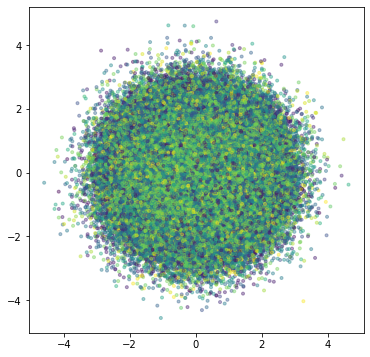

In [22]:
# Plot with merchant_category_id color
plt_reduce(x_reduce, 'merchant_category_id')

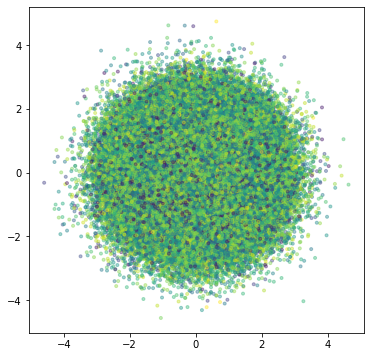

In [23]:
# Plot with subsector_id color
plt_reduce(x_reduce, 'subsector_id')

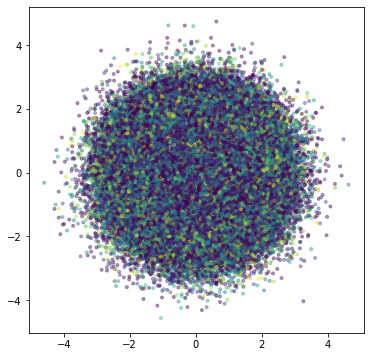

In [24]:
# Plot with city_id color
plt_reduce(x_reduce, 'city_id')

### Save Embedding

Join embedding with merchant_id and save pandas

In [ ]:
df_embedding = pd.DataFrame(z_df)
df_embedding['merchant_id'] = df.merchant_id
df_embedding.head(5)

In [ ]:
df_embedding.to_csv('merchant_id_embedding.csv')